# Stroke prediction

Can we predict the number of admissions for each MSOA using the patient demographics?

This notebook uses the age bands (0-64, 65-79, and 80+ years old), Index of Mean Deprivation, and health bands (good health, fair health, and bad health).


## Code setup

In [1]:
import os
import polars as pl
import numpy as np

from scipy.optimize import minimize
import statsmodels.api as sm  # for linear regression

import matplotlib.pyplot as plt

## Load data

Patient demographics by MSOA:

In [2]:
path_to_msoa_stats = os.path.join('data', 'msoa_collated.csv')

df_stats = pl.read_csv(path_to_msoa_stats)

In [3]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761


Check sum of admissions for Welsh areas:

In [4]:
df_stats.filter(df_stats['country'] == 'W')['admissions'].sum()

0.0

Welsh data is always zero so remove it.

In [5]:
df_stats = df_stats.filter(df_stats['country'] != 'W')

## Check data stats

Check the range of values in the data and whether they seem correlated with admissions numbers.

Check for these columns which will be used in the model:

In [6]:
cols_to_check = [
    'prop_0-64',
    'prop_65-79',
    'prop_80+',
    'prop_good_health',
    'prop_fair health',
    'prop_bad health',
    'IMD2019Score',
]

Calculate some statistics:

In [7]:
dict_stats = {}
for prop in cols_to_check:
    p = df_stats[prop]
    d = df_stats['admissions'] / p
    c = np.cov(df_stats['admissions'], p)[0][1]

    dict_stats[prop] = {}
    dict_stats[prop]['mean'] = p.mean()
    dict_stats[prop]['std'] = p.std()
    dict_stats[prop]['admissions_div_prop_mean'] = d.mean()
    dict_stats[prop]['admissions_div_prop_std'] = d.std()
    dict_stats[prop]['cov'] = c

Display them in a DataFrame:

In [8]:
df_stats_stats = pl.from_dicts(list(dict_stats.values()))

# df_stats_stats['props'] = list(dict_stats.keys())
df_stats_stats.insert_column(index=0, column=pl.Series('prop', list(dict_stats.keys())))

prop,mean,std,admissions_div_prop_mean,admissions_div_prop_std,cov
str,f64,f64,f64,f64,f64
"""prop_0-64""",0.812175,0.069263,15.022188,6.563548,-0.142042
"""prop_65-79""",0.136804,0.049879,96.215761,45.183577,0.093329
"""prop_80+""",0.051021,0.021846,266.410472,137.175779,0.048713
"""prop_good_health""",0.812839,0.043983,14.834584,6.005458,-0.079966
"""prop_fair health""",0.132006,0.026105,90.672826,30.600641,0.054816
"""prop_bad health""",0.055154,0.020116,235.202158,102.76941,0.02515
"""IMD2019Score""",21.638473,13.244139,0.801173,0.649843,2.201578


Scatter the data to see by eye whether there is a correlation with admissions numbers.

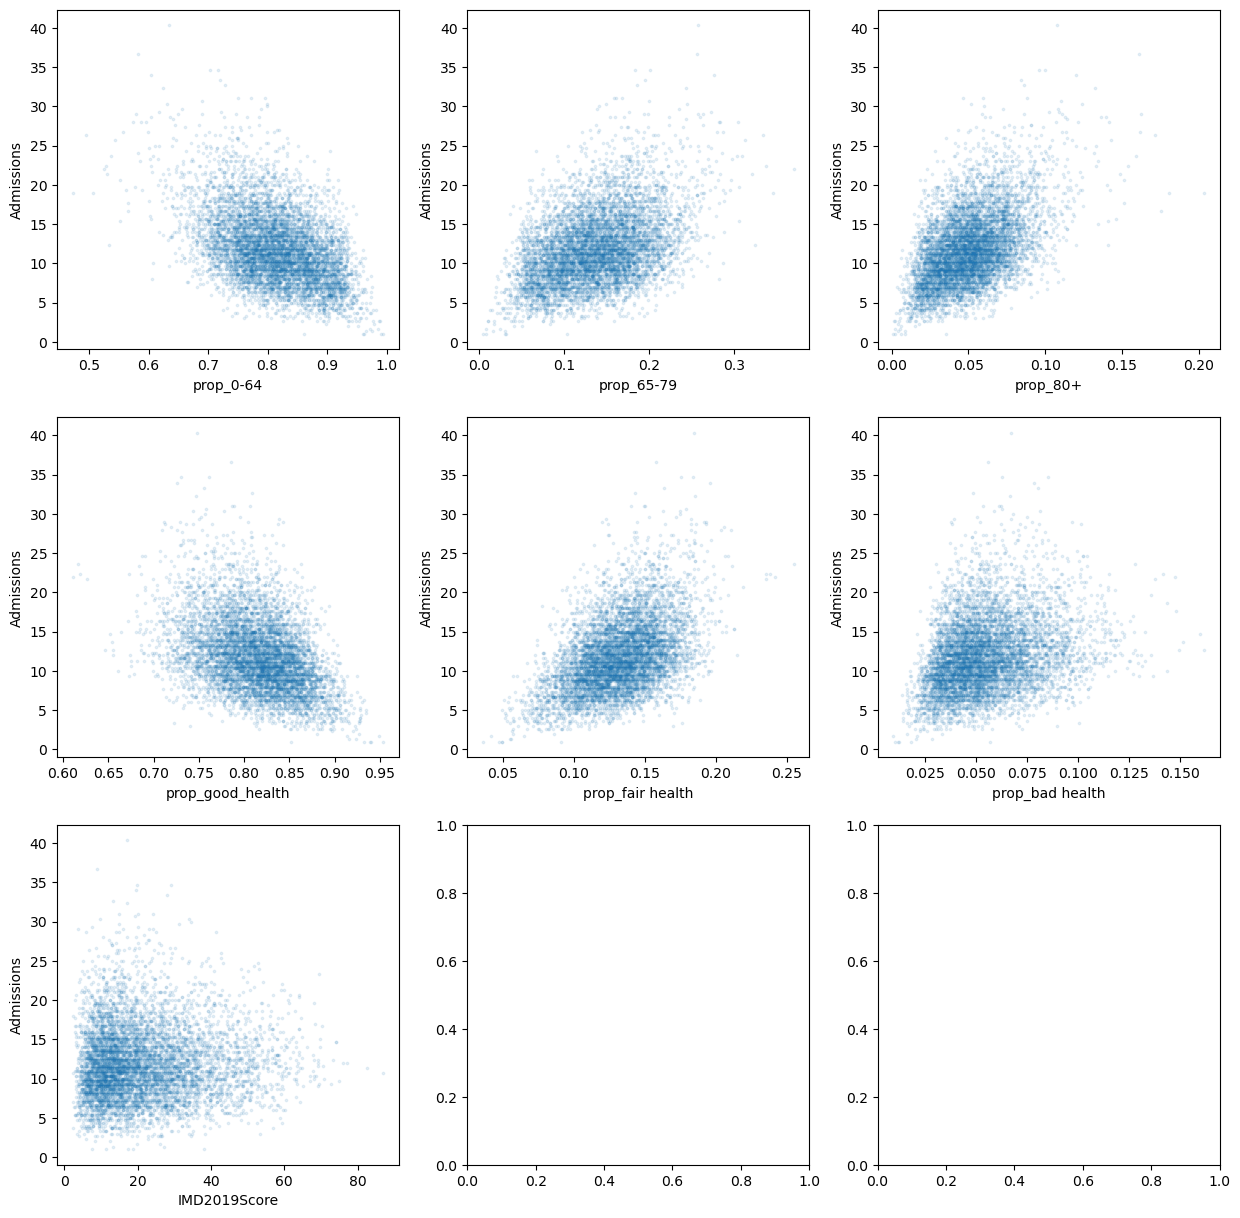

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for c, col in enumerate(cols_to_check):
    ax = axs[c // 3, c % 3]
    ax.scatter(df_stats[col], df_stats['admissions'], s=3, alpha=0.1)
    ax.set_xlabel(col)
    ax.set_ylabel('Admissions')
plt.show()

## Set up functions

This multiplies coefficients by the data:

In [10]:
def predict_admissions(x_lists, coeffs):
    """
    x_lists: np.array.
    coeffs: np.array.
    
    Have to have same number of coeffs as x_lists.
    """
    # Predicted admissions:
    yhat = (x_lists * coeffs.reshape(len(coeffs), 1)).sum(axis=0)
    return yhat
    

This calculates the sum of the square of the differences between predicted and actual admission numbers:

In [11]:
def find_square_residuals(yhat, y):
    # Difference from actual:
    sqres = (yhat - y)**2.0
    # Sum of differences:
    sum_sqres = sqres.sum()
    return sum_sqres

This makes a quick plot of predicted vs admissions numbers:

In [12]:
def plot_y_vs_yhat(y, yhat):
    fig, ax = plt.subplots()

    # Draw the data:
    ax.scatter(y, yhat, s=2, alpha=0.1)

    # Draw a line diagonally:
    ax.set_aspect('equal')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    vmin = min([xmin, ymin])
    vmax = max([xmax, ymax])
    ax.plot([0, vmax], [0, vmax], color='k', linewidth=1)
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    
    plt.show()

## Linear regression

Use the `statsmodels` package to create Ordinary Least Squares linear regression models for certain parts of the data.

### Age bands only

In [13]:
y = df_stats['admissions'].to_numpy()
X = df_stats[['prop_0-64', 'prop_65-79', 'prop_80+']].to_numpy()

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1092.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:40:57   Log-Likelihood:                -18930.
No. Observations:                6790   AIC:                         3.787e+04
Df Residuals:                    6787   BIC:                         3.789e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.7246      0.139     48.258      0.0

In [14]:
age_coeffs_lr = results.params

age_coeffs_lr

array([  6.72459018,   6.48626766, 109.25380067])

### IMD and age bands

In [15]:
y = df_stats['admissions'].to_numpy()
X = df_stats[['prop_0-64', 'prop_65-79', 'prop_80+', 'IMD2019Score']].to_numpy()

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     1054.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:40:57   Log-Likelihood:                -18578.
No. Observations:                6790   AIC:                         3.716e+04
Df Residuals:                    6786   BIC:                         3.719e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8392      0.195     14.590      0.0

In [16]:
imd_age_coeffs_lr = results.params

imd_age_coeffs_lr

array([2.83915840e+00, 9.77332839e+00, 1.18181889e+02, 1.04002285e-01])

### Health, IMD and age bands

In [17]:
y = df_stats['admissions'].to_numpy()
X = df_stats[['prop_0-64', 'prop_65-79', 'prop_80+', 'IMD2019Score', 'prop_good_health', 'prop_fair health', 'prop_bad health']].to_numpy()

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     718.1
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:40:57   Log-Likelihood:                -18435.
No. Observations:                6790   AIC:                         3.688e+04
Df Residuals:                    6784   BIC:                         3.692e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2550      1.184     -1.060      0.2

In [18]:
health_imd_age_coeffs_lr = results.params

health_imd_age_coeffs_lr

array([-1.25500602e+00, -6.72545635e+00,  9.06909120e+01, -2.00573344e-02,
        2.27629929e+00,  4.40169057e+01,  3.64172447e+01])

## Optimiser

### Age coefficients

Manually change the coeffs until there's something that resembles a fit to a straight line:

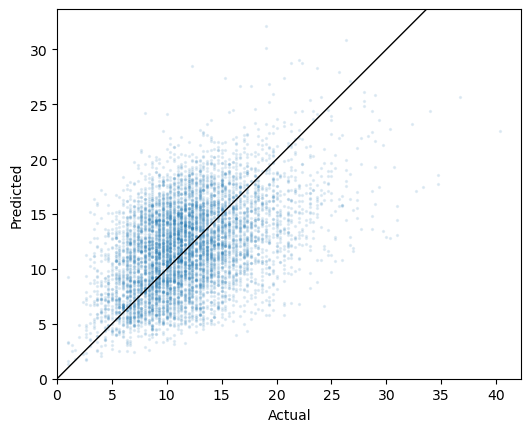

In [19]:
age_coeffs = np.array([1, 60, 60])
x_lists_age = np.array([df_stats['prop_0-64'], df_stats['prop_65-79'], df_stats['prop_80+']])

yhat = predict_admissions(x_lists_age, age_coeffs)

plot_y_vs_yhat(df_stats['admissions'], yhat)

Run those coeffs through the minimiser:

In [20]:
def main_age(coeffs, args):
    x_lists = args[0]
    admissions = args[1]
    yhat = predict_admissions(x_lists, coeffs)
    sum_sqres = find_square_residuals(yhat, admissions)
    return sum_sqres

In [21]:
args = [
    [df_stats['prop_0-64'], df_stats['prop_65-79'], df_stats['prop_80+']],
    df_stats['admissions']
]

opt_results = minimize(
    main_age,
    x0=age_coeffs,
    args=args,
    bounds=[(0.0, None)] * len(age_coeffs),
    method='Nelder-Mead'
)

Results:

In [22]:
opt_results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 104945.49148508397
             x: [ 6.725e+00  6.486e+00  1.093e+02]
           nit: 130
          nfev: 232
 final_simplex: (array([[ 6.725e+00,  6.486e+00,  1.093e+02],
                       [ 6.725e+00,  6.486e+00,  1.093e+02],
                       [ 6.725e+00,  6.486e+00,  1.093e+02],
                       [ 6.725e+00,  6.486e+00,  1.093e+02]]), array([ 1.049e+05,  1.049e+05,  1.049e+05,  1.049e+05]))

In [23]:
age_coeffs_opt = opt_results['x']

age_coeffs_opt

array([  6.72458637,   6.48627251, 109.25382989])

Compare with results of the linear regression:

In [24]:
tab = [
    ['prop_0-64', 'prop_65-79', 'prop_80+'],
    age_coeffs_lr,
    age_coeffs_opt
]

pl.DataFrame(tab, schema=['Variable', 'Linear regression', 'Optimiser'])

Variable,Linear regression,Optimiser
str,f64,f64
"""prop_0-64""",6.72459,6.724586
"""prop_65-79""",6.486268,6.486273
"""prop_80+""",109.253801,109.25383


Display fit:

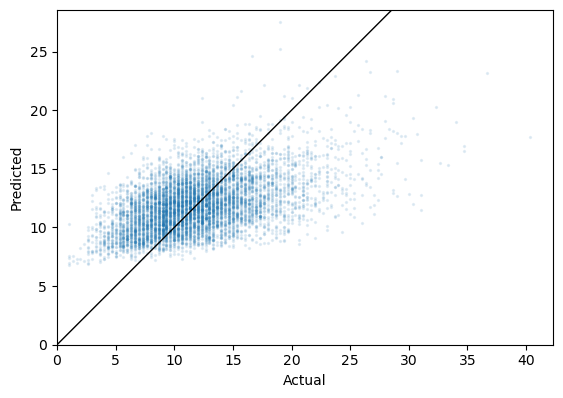

In [25]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)

plot_y_vs_yhat(df_stats['admissions'], yhat)

### IMD coefficients

Fix the age coeffs from above then add in the IMD coeff.

Manually change the coeff until there's something that resembles a fit to a straight line:

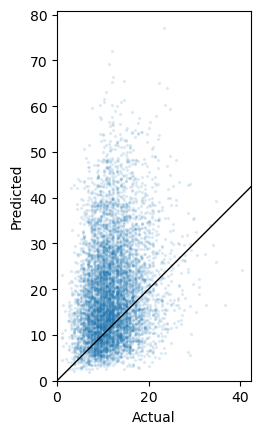

In [26]:
imd_coeffs = np.array([0.08])
x_lists_imd = np.array([df_stats['IMD2019Score']])

yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, imd_coeffs)

plot_y_vs_yhat(df_stats['admissions'], yhatdash)

Run those coeffs through the minimiser:

In [27]:
def main_imd(coeffs, args):
    x_lists_imd = args[0]
    admissions = args[1]
    yhat = args[2]

    yhatdash = yhat * predict_admissions(x_lists_imd, coeffs)
    
    sum_sqres = find_square_residuals(yhatdash, admissions)
    return sum_sqres

In [28]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)

args = [
    [df_stats['IMD2019Score']],
    df_stats['admissions'],
    yhat,
]

opt_results_imd = minimize(
    main_imd,
    x0=imd_coeffs,
    args=args,
    method='Nelder-Mead',
)#, bounds=[(0.0, None)] * len(imd_coeffs))

Results:

In [29]:
opt_results_imd

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 301744.4216573639
             x: [ 3.876e-02]
           nit: 20
          nfev: 40
 final_simplex: (array([[ 3.876e-02],
                       [ 3.876e-02]]), array([ 3.017e+05,  3.017e+05]))

In [30]:
opt_coeffs_imd = opt_results_imd['x']

opt_coeffs_imd

array([0.03875977])

Compare with results of the linear regression:

In [31]:
props_cols = ['prop_0-64', 'prop_65-79', 'prop_80+', 'IMD2019Score']

pl.DataFrame(
    [props_cols, imd_age_coeffs_lr, np.concatenate((age_coeffs_opt, opt_coeffs_imd))],
    schema=['Variable', 'Linear regression', 'Iterative optimiser']
)

Variable,Linear regression,Iterative optimiser
str,f64,f64
"""prop_0-64""",2.839158,6.724586
"""prop_65-79""",9.773328,6.486273
"""prop_80+""",118.181889,109.25383
"""IMD2019Score""",0.104002,0.03876


Display fit:

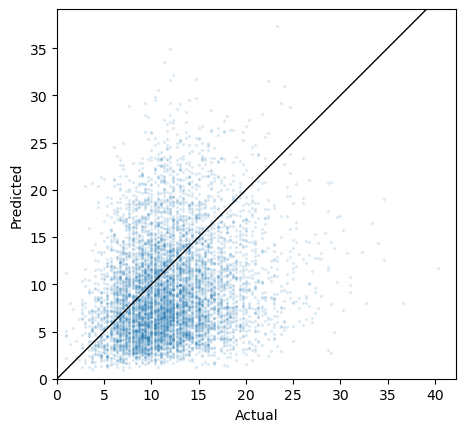

In [32]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, opt_coeffs_imd)

plot_y_vs_yhat(df_stats['admissions'], yhatdash)

### Health state coefficients

Fix the IMD and age coeffs from above then add in the health state coefficients.

Manually change the coeff until there's something that resembles a fit to a straight line:

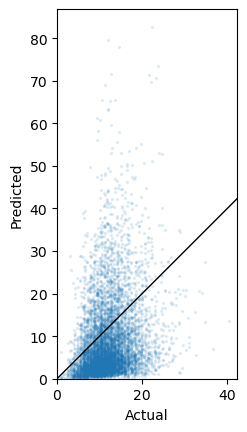

In [33]:
health_coeffs = np.array([5, 5, 5])
x_lists_health = np.array([df_stats['prop_good_health'], df_stats['prop_fair health'], df_stats['prop_bad health']])

yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, opt_coeffs_imd)

yhatdashdash = yhatdash.copy()
for i, x_list in enumerate(x_lists_health):
    coeff = health_coeffs[i]
    yhatdashdash = yhatdashdash * predict_admissions(np.array([x_list]), np.array([coeff]))

plot_y_vs_yhat(df_stats['admissions'], yhatdashdash)

Run those coeffs through the minimiser:

In [34]:
def main_health(coeffs, args):
    x_lists_health = args[0]
    admissions = args[1]
    yhatdash = args[2]

    yhatdashdash = yhatdash.copy()
    for i, x_list in enumerate(x_lists_health):
        coeff = coeffs[i]
        yhatdashdash = yhatdashdash * predict_admissions(np.array([x_list]), np.array([coeff]))
    
    sum_sqres = find_square_residuals(yhatdashdash, admissions)
    return sum_sqres

In [35]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, opt_coeffs_imd)

args = [
    [df_stats['prop_good_health'], df_stats['prop_fair health'], df_stats['prop_bad health']],
    df_stats['admissions'],
    yhatdash,
]

opt_results_health = minimize(
    main_health,
    x0=health_coeffs,
    args=args,
    method='Nelder-Mead',
)#, bounds=[(0.0, None)] * len(imd_coeffs))

Results

In [36]:
opt_results_health

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 545570.8642983293
             x: [ 5.371e+00  3.917e+00  4.214e+00]
           nit: 47
          nfev: 94
 final_simplex: (array([[ 5.371e+00,  3.917e+00,  4.214e+00],
                       [ 5.371e+00,  3.917e+00,  4.214e+00],
                       [ 5.371e+00,  3.916e+00,  4.214e+00],
                       [ 5.371e+00,  3.917e+00,  4.214e+00]]), array([ 5.456e+05,  5.456e+05,  5.456e+05,  5.456e+05]))

In [37]:
opt_coeffs_health = opt_results_health['x']

opt_coeffs_health

array([5.37081106, 3.91654428, 4.21375962])

Compare with results of the linear regression:

In [38]:
props_cols = [
    'prop_0-64',
    'prop_65-79',
    'prop_80+',
    'IMD2019Score',
    'prop_good_health',
    'prop_fair health',
    'prop_bad health'
]

pl.DataFrame(
    [
        props_cols,
        health_imd_age_coeffs_lr,
        np.concatenate((age_coeffs_opt, opt_coeffs_imd, opt_coeffs_health))
    ],
    schema=['Variable', 'Linear regression', 'Iterative optimiser']
)

Variable,Linear regression,Iterative optimiser
str,f64,f64
"""prop_0-64""",-1.255006,6.724586
"""prop_65-79""",-6.725456,6.486273
"""prop_80+""",90.690912,109.25383
"""IMD2019Score""",-0.020057,0.03876
"""prop_good_health""",2.276299,5.370811
"""prop_fair health""",44.016906,3.916544
"""prop_bad health""",36.417245,4.21376


Display fit:

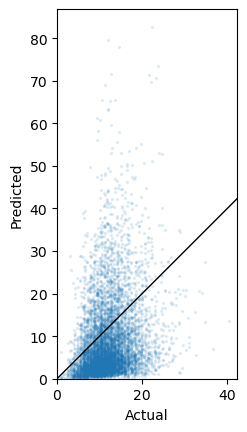

In [39]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, opt_coeffs_imd)

yhatdashdash = yhatdash.copy()
for i, x_list in enumerate(x_lists_health):
    coeff = health_coeffs[i]
    yhatdashdash = yhatdashdash * predict_admissions(np.array([x_list]), np.array([coeff]))

plot_y_vs_yhat(df_stats['admissions'], yhatdashdash)

## Calculate R-squared values

Function to calculate R-squared. This gives the same results as the sklearn built-in.

In [40]:
def calculate_rsquared(y, yhat):
    y_mean = y.mean()
    ss_res = ((yhat - y)**2.0).sum()
    ss_tot = ((y - y_mean)**2.0).sum()
    rsq = 1.0 - ss_res / ss_tot
    return rsq

Iterative fits:

In [41]:
rsq_age = calculate_rsquared(df_stats['admissions'], yhat)
rsq_imd_age = calculate_rsquared(df_stats['admissions'], yhatdash)
rsq_health_imd_age = calculate_rsquared(df_stats['admissions'], yhatdashdash)

Linear regression:

In [42]:
np.array([imd_age_coeffs_lr[-1]])

array([0.10400228])

In [43]:
yhat_lr = predict_admissions(x_lists_age, age_coeffs_lr)

yhatdash_lr = predict_admissions(np.concatenate((x_lists_age, x_lists_imd)), imd_age_coeffs_lr)


yhatdashdash_lr = predict_admissions(np.concatenate((x_lists_age, x_lists_imd, x_lists_health)), health_imd_age_coeffs_lr)

In [44]:
rsq_age_lr = calculate_rsquared(df_stats['admissions'], yhat_lr)
rsq_imd_age_lr = calculate_rsquared(df_stats['admissions'], yhatdash_lr)
rsq_health_imd_age_lr = calculate_rsquared(df_stats['admissions'], yhatdashdash_lr)

Display results:

In [45]:
tab = [
        ['Age', rsq_age_lr, rsq_age],
        ['IMD & age', rsq_imd_age_lr, rsq_imd_age],
        ['Health, IMD & age', rsq_health_imd_age_lr, rsq_health_imd_age]
    ]

pl.DataFrame(tab, schema=['Variables used', 'Linear regression', 'Iterative fits'], orient='row')

Variables used,Linear regression,Iterative fits
str,f64,f64
"""Age""",0.243376,0.243376
"""IMD & age""",0.3179,-1.175482
"""Health, IMD & age""",0.346099,-3.610952


## Comparison plots

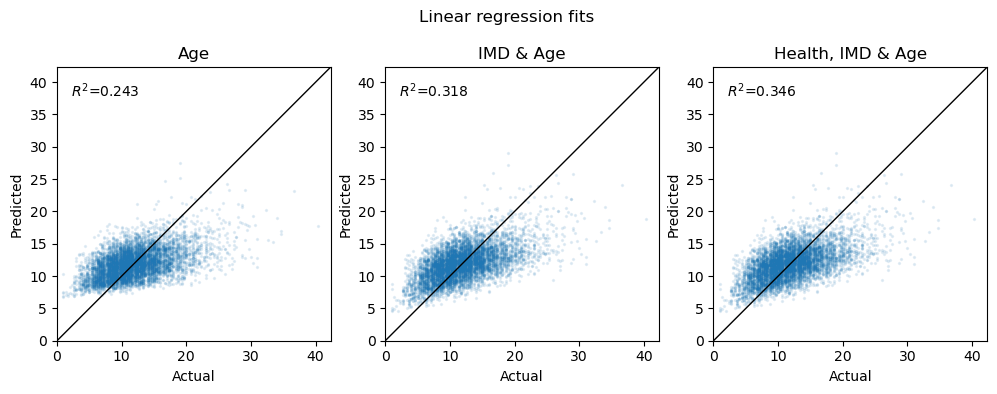

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Draw the data:
axs[0].scatter(y, yhat_lr, s=2, alpha=0.1)
axs[1].scatter(y, yhatdash_lr, s=2, alpha=0.1)
axs[2].scatter(y, yhatdash_lr, s=2, alpha=0.1)

# Find shared axis limits:
vmin = 10
vmax = 20
for ax in axs:
    ax.set_aspect('equal')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    vmin = min([vmin, xmin, ymin])
    vmax = max([vmax, xmax, ymax])
for ax in axs:
    # Draw a line diagonally:
    ax.plot([vmin, vmax], [vmin, vmax], color='k', linewidth=1)
    ax.set_xlim(0, vmax)
    ax.set_ylim(0, vmax)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

axs[0].annotate(r'$R^{2}$=' + f'{rsq_age_lr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[1].annotate(r'$R^{2}$=' + f'{rsq_imd_age_lr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate(r'$R^{2}$=' + f'{rsq_health_imd_age_lr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

axs[0].set_title('Age')
axs[1].set_title('IMD & Age')
axs[2].set_title('Health, IMD & Age')

fig.suptitle('Linear regression fits')

plt.show()

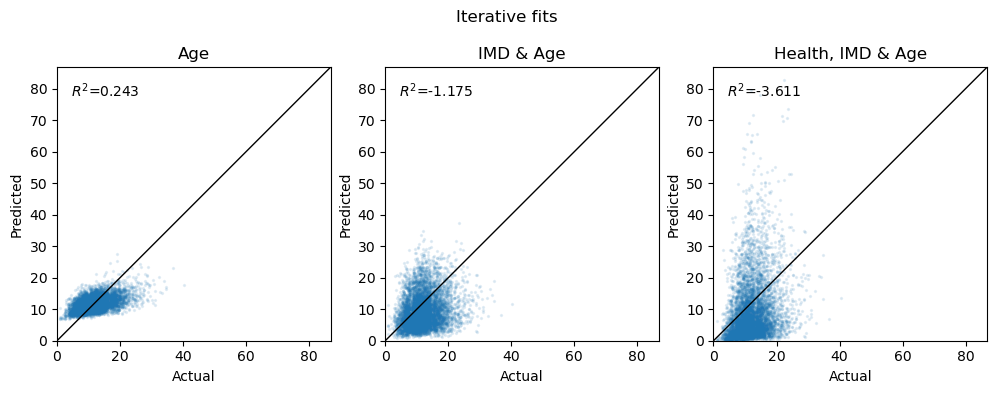

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Draw the data:
axs[0].scatter(y, yhat, s=2, alpha=0.1)
axs[1].scatter(y, yhatdash, s=2, alpha=0.1)
axs[2].scatter(y, yhatdashdash, s=2, alpha=0.1)

# Find shared axis limits:
vmin = 10
vmax = 20
for ax in axs:
    ax.set_aspect('equal')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    vmin = min([vmin, xmin, ymin])
    vmax = max([vmax, xmax, ymax])
for ax in axs:
    # Draw a line diagonally:
    ax.plot([vmin, vmax], [vmin, vmax], color='k', linewidth=1)
    ax.set_xlim(0, vmax)
    ax.set_ylim(0, vmax)

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

axs[0].annotate(r'$R^{2}$=' + f'{rsq_age:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[1].annotate(r'$R^{2}$=' + f'{rsq_imd_age:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate(r'$R^{2}$=' + f'{rsq_health_imd_age:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

axs[0].set_title('Age')
axs[1].set_title('IMD & Age')
axs[2].set_title('Health, IMD & Age')

fig.suptitle('Iterative fits')

plt.show()